In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from etl.db_requests import get_power_data
from etl.etl import (
    csv_einlesen_ordner,
    read_power_api,
    transform_csv,
    transform_api,
    transform,
    laden_in_db,
    )
from sklearn.cluster import KMeans

In [13]:
energy_keys = {
    "Stromerzeugung: Braunkohle": 1223,
    "Stromerzeugung: Wind Offshore": 1225,
    "Stromerzeugung: Wasserkraft": 1226,
    "Stromerzeugung: Sonstige Konventionelle": 1227,
    "Stromerzeugung: Sonstige Erneuerbare": 1228,
    "Stromerzeugung: Biomasse": 4066,
    "Stromerzeugung: Wind Onshore": 4067,
    "Stromerzeugung: Photovoltaik": 4068,
    "Stromerzeugung: Steinkohle": 4069,
    "Stromerzeugung: Pumpspeicher": 4070,
    "Stromerzeugung: Erdgas": 4071,
    "Stromverbrauch: Gesamt (Netzlast)": 410
}

In [14]:
def panda_check(df):
    print(df.head(10))

    print(df.info())
    print(df.describe())


df_csv = csv_einlesen_ordner("CSV_files")
df_api = read_power_api(api_keys=energy_keys, n_weeks=11)

df_csv = transform_csv(df_csv)
df_api = transform_api(df_api)

df_list = [df_csv, df_api]

df= transform(df_list)
laden_in_db(df)
panda_check(df)


Einige Zeilen waren doppelt und wurden ignoriert.
            Timestamp  Biomasse  Wasserkraft  Wind Offshore  Wind Onshore  \
0 2024-12-02 00:00:00   4076.75      1431.75        6012.75      22238.50   
1 2024-12-02 01:00:00   4042.25      1416.25        5906.50      21720.50   
2 2024-12-02 02:00:00   4036.75      1427.50        5717.25      21031.25   
3 2024-12-02 03:00:00   4024.00      1400.50        5704.50      20206.50   
4 2024-12-02 04:00:00   4036.50      1385.00        5635.75      20185.75   
5 2024-12-02 05:00:00   4099.25      1398.25        5600.25      19966.25   
6 2024-12-02 06:00:00   4280.50      1494.50        5755.25      20343.50   
7 2024-12-02 07:00:00   4516.25      1669.75        5900.25      20133.25   
8 2024-12-02 08:00:00   4638.25      1742.75        5972.50      20314.25   
9 2024-12-02 09:00:00   4608.00      1774.00        5707.25      19875.25   

   Photovoltaik  Sonstige Erneuerbare  Braunkohle  Steinkohle    Erdgas  \
0          7.25            

In [15]:
df = get_power_data()
df.set_index('Timestamp', inplace=True)

numeric_cols = df.select_dtypes(include='number').columns
non_numeric_cols = df.select_dtypes(exclude='number').columns
daily_mean = df[numeric_cols].resample('D').mean()
daily_non_numeric = df[non_numeric_cols].resample('D').first()
df_daily = pd.concat([daily_mean, daily_non_numeric], axis=1).dropna(axis=0, how='any')


df_day = df.loc[df['Tageszeit'] == 'Tag']
numeric_cols = df_day.select_dtypes(include='number').columns
non_numeric_cols = df_day.select_dtypes(exclude='number').columns
day_daily_mean = df_day[numeric_cols].resample('D').mean()
day_daily_non_numeric = df_day[non_numeric_cols].resample('D').first()
df_day_daily = pd.concat([day_daily_mean, day_daily_non_numeric], axis=1).dropna(axis=0, how='any')


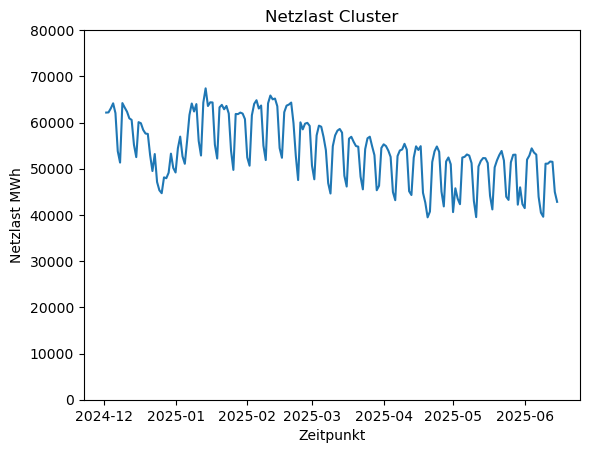

In [16]:
fig, ax = plt.subplots()
ax.set_title('Netzlast Cluster')
ax.plot(df_daily.index, df_daily['Netzlast'])
ax.set_ylim(0, 80000)
ax.set_xlabel('Zeitpunkt')
ax.set_ylabel('Netzlast MWh')
plt.show()

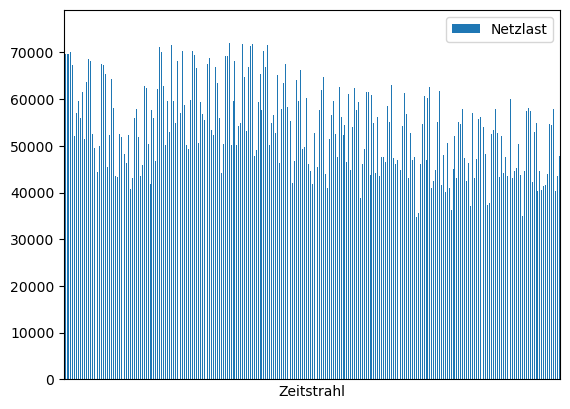

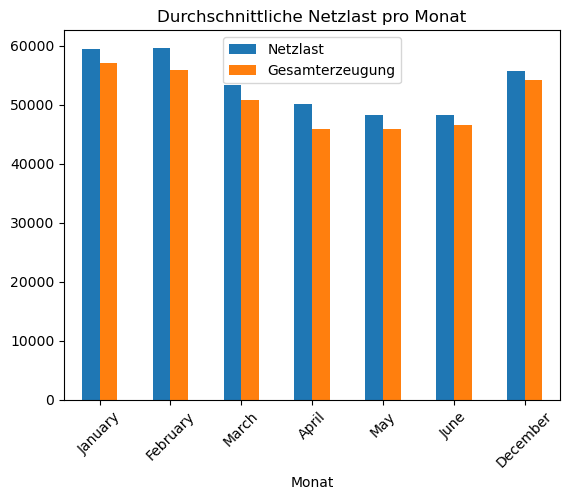

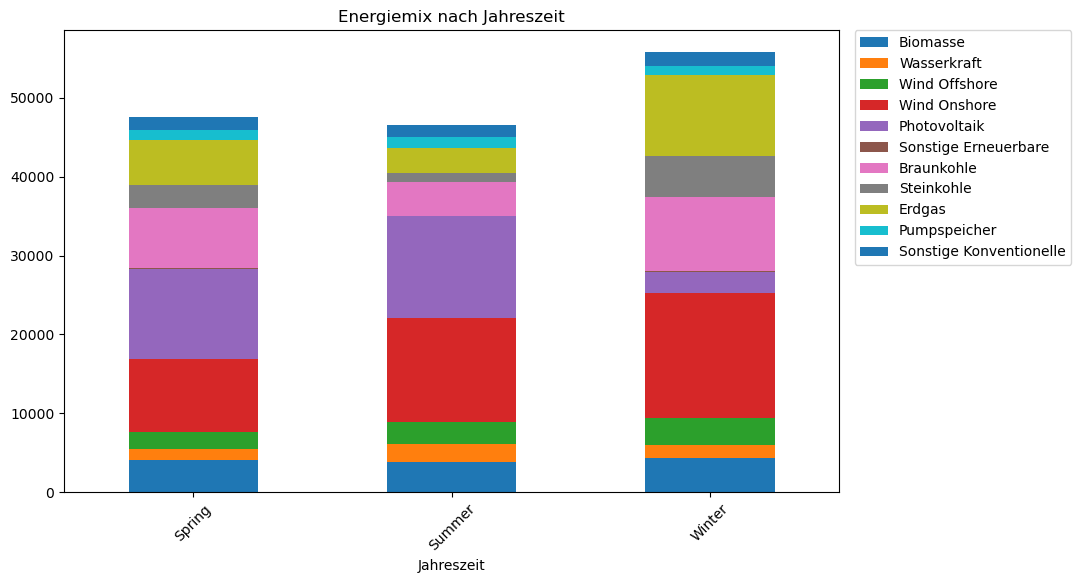

In [17]:
df.plot(x="Monat", y = "Netzlast", kind = "bar")
plt.xticks([])
plt.xlabel("Zeitstrahl")

monat_avg = df.groupby('Monat')[['Netzlast', 'Gesamterzeugung']].mean().reset_index()

monatsreihenfolge = ["January", "February", "March", "April", "May", "June",
                     "July", "August", "September", "October", "November", "December"]

jahreszeit_avg = df.groupby('Jahreszeit')[["Biomasse", "Wasserkraft","Wind Offshore", "Wind Onshore", "Photovoltaik","Sonstige Erneuerbare","Braunkohle","Steinkohle","Erdgas","Pumpspeicher","Sonstige Konventionelle"]].mean().reset_index()

# Setze die Monats-Spalte als kategorisch mit fester Reihenfolge
monat_avg['Monat'] = pd.Categorical(monat_avg['Monat'], categories=monatsreihenfolge, ordered=True)

# Sortiere nach der Monatsreihenfolge
monat_avg = monat_avg.sort_values('Monat')
monat_avg.plot(x='Monat', y=['Netzlast', 'Gesamterzeugung'], kind='bar', title='Durchschnittliche Netzlast pro Monat')
plt.xticks(rotation=45)
plt.show()



# jahreszeit_avg.plot(x='Jahreszeit', y=["Biomasse", "Wasserkraft","Wind Offshore", "Wind Onshore", "Photovoltaik","Sonstige Erneuerbare","Braunkohle","Steinkohle","Erdgas","Pumpspeicher","Sonstige Konventionelle"], kind='bar', title='Energiemix nach Jahreszeit', stacked=True)
# plt.xticks(rotation=45)
# plt.ylim(0,100000)
# plt.tight_layout()
# plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

jahreszeit_avg.plot(
    x='Jahreszeit',
    y=["Biomasse", "Wasserkraft", "Wind Offshore", "Wind Onshore", "Photovoltaik",
       "Sonstige Erneuerbare", "Braunkohle", "Steinkohle", "Erdgas",
       "Pumpspeicher", "Sonstige Konventionelle"],
    kind='bar',
    stacked=True,
    title='Energiemix nach Jahreszeit',
    ax=ax
)


ax.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0
)


plt.xticks(rotation=45)
plt.show()

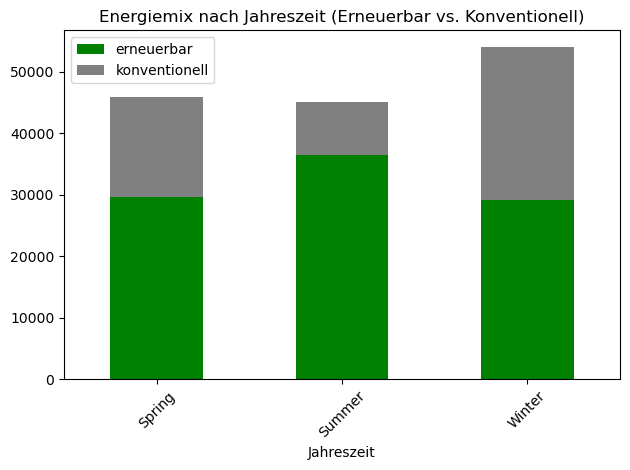

In [18]:
konventionell= ["Braunkohle", "Steinkohle", "Erdgas", "sonstige Konventionelle"]
erneuerbar= ["Biomasse", "Wasserkraft", "Wind Offshore", "Wind Onshore", "Photovoltaik", "Sonstige Erneuerbare", "Pumpspeicher"]

for energy in erneuerbar + konventionell:
    if energy not in jahreszeit_avg.columns:
        jahreszeit_avg[energy] = 0


jahreszeit_avg["erneuerbar"] = jahreszeit_avg[erneuerbar].sum(axis=1)
jahreszeit_avg["konventionell"] = jahreszeit_avg[konventionell].sum(axis=1)



jahreszeit_avg[["Jahreszeit", "erneuerbar", "konventionell"]].set_index("Jahreszeit").plot(
    kind="bar",
    stacked=True,
    color=["green", "gray"],
    title="Energiemix nach Jahreszeit (Erneuerbar vs. Konventionell)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

c:\Users\kmerlot\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


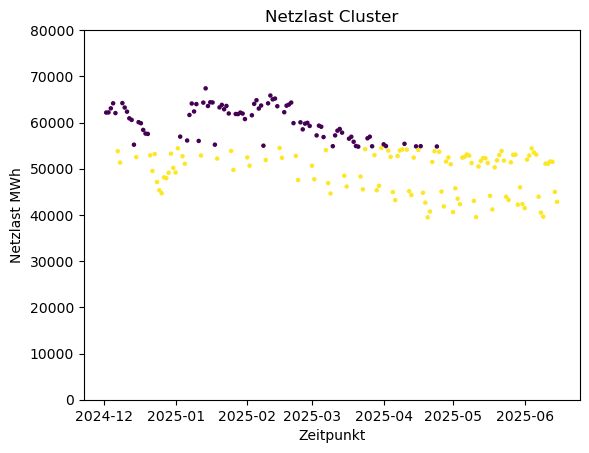

,Biomasse,Wasserkraft,Wind Offshore,Wind Onshore,Photovoltaik,Sonstige Erneuerbare,Braunkohle,Steinkohle,Erdgas,Pumpspeicher,Sonstige Konventionelle,Netzlast,Gesamterzeugung,Erneuerbare,Konventionelle,Monat,Tageszeit,Jahreszeit,Cluster_workdays_1
Timestamp,,,,,,,,,,,,,,,,,,,
2024-12-02,4375.989583,1629.145833,4487.697917,18588.145833,1221.458333,135.229167,11106.479167,4491.854167,10612.260417,1243.437500,1802.885417,62153.395833,59694.583333,31681.104167,28013.479167,December,Nacht,Winter,Workday
2024-12-03,4399.489583,1876.666667,4158.020833,12656.531250,1539.031250,130.781250,12352.770833,5665.083333,13352.416667,1041.322917,1850.760417,62192.291667,59022.875000,25801.843750,33221.031250,December,Nacht,Winter,Workday
2024-12-04,4468.500000,2020.218750,1690.666667,5637.385417,1507.239583,134.500000,12638.125000,6065.875000,14866.562500,1790.458333,1861.208333,63068.270833,52680.739583,17248.968750,35431.770833,December,Nacht,Winter,Workday
2024-12-05,4377.385417,1700.291667,3991.708333,22431.458333,2511.760417,135.729167,11073.125000,4441.864583,9614.250000,681.062500,1815.927083,64157.760417,62774.562500,35829.395833,26945.166667,December,Nacht,Winter,Workday
2024-12-06,4390.760417,1699.312500,3701.937500,28608.625000,1061.666667,137.281250,9035.406250,3682.343750,7048.447917,1643.906250,1786.416667,62040.937500,62796.104167,41243.489583,21552.614583,December,Nacht,Winter,Workday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-11,3888.177083,2117.937500,1767.583333,10337.177083,16712.135417,92.000000,4538.260417,1516.468750,3795.083333,1745.937500,1477.958333,51096.406250,47988.718750,36660.947917,11327.770833,June,Nacht,Summer,Day off
2025-06-12,3874.000000,2171.145833,2251.406250,10963.260417,18384.729167,87.520833,4557.093750,1892.312500,3114.281250,1563.708333,1379.000000,51561.197917,50238.458333,39295.770833,10942.687500,June,Nacht,Summer,Day off
2025-06-13,3885.458333,2137.041667,3596.802083,15167.218750,18613.447917,91.802083,4261.135417,1252.656250,3543.666667,1609.687500,1502.218750,51493.947917,55661.135417,45101.458333,10559.677083,June,Nacht,Summer,Day off


In [19]:
predictor = KMeans(n_clusters=2, random_state=42, n_init="auto")
y_pred = predictor.fit_predict(df_daily['Netzlast'].to_numpy().reshape(-1, 1))
fig, ax = plt.subplots()
ax.set_title('Netzlast Cluster')
ax.scatter(df_daily.index, df_daily['Netzlast'], c=y_pred, s=5)
ax.set_ylim(0, 80000)
ax.set_xlabel('Zeitpunkt')
ax.set_ylabel('Netzlast MWh')
plt.show()

df_daily['Cluster_workdays_1'] = y_pred
df_daily['Cluster_workdays_1'] = np.select([y_pred == 0, y_pred == 1], ['Workday', 'Day off'], default=None)
df_daily

c:\Users\kmerlot\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


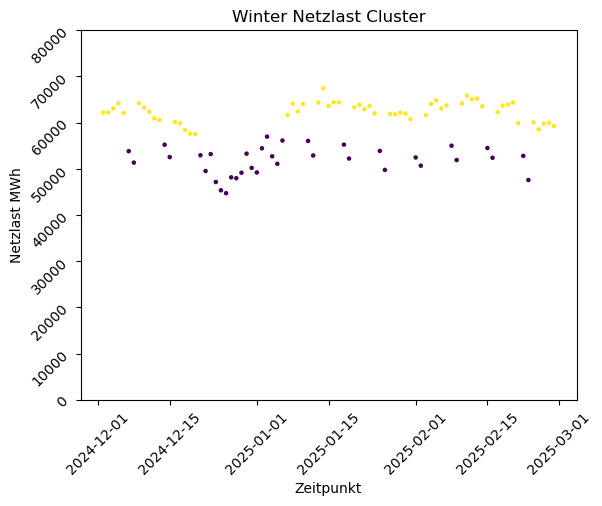

C:\Users\kmerlot\AppData\Local\Temp\ipykernel_436\3245124447.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_winter['Cluster_workdays_2'] = np.select([y_pred == 0, y_pred == 1], ['Day off', 'Workday'], default=None)


Timestamp
2024-12-02    Workday
2024-12-03    Workday
2024-12-04    Workday
2024-12-05    Workday
2024-12-06    Workday
               ...   
2025-02-24    Workday
2025-02-25    Workday
2025-02-26    Workday
2025-02-27    Workday
2025-02-28    Workday
Freq: D, Name: Cluster_workdays_2, Length: 89, dtype: object

In [20]:
predictor = KMeans(
    n_clusters=2,
    random_state=42,
    n_init="auto"
    )
y_pred = predictor.fit_predict(df_daily.loc[df_daily['Jahreszeit'] == 'Winter']['Netzlast'].to_numpy().reshape(-1, 1))
fig, ax = plt.subplots()
ax.set_title('Winter Netzlast Cluster')
ax.scatter(
    df_daily.loc[df_daily['Jahreszeit'] == 'Winter'].index,
    df_daily.loc[df_daily['Jahreszeit'] == 'Winter']['Netzlast'],
    c=y_pred,
    s=5
    )
ax.set_ylim(0, 80000)
ax.set_xlabel('Zeitpunkt')
ax.set_ylabel('Netzlast MWh')
ax.tick_params(labelrotation=45)
plt.show()

df_daily_winter = df_daily.loc[df_daily['Jahreszeit'] == 'Winter']
df_daily_winter['Cluster_workdays_2'] = np.select([y_pred == 0, y_pred == 1], ['Day off', 'Workday'], default=None)
df_daily_winter['Cluster_workdays_2']

c:\Users\kmerlot\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


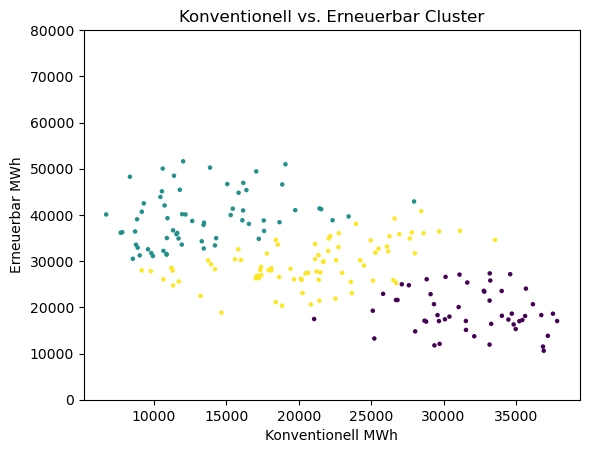

C:\Users\kmerlot\AppData\Local\Temp\ipykernel_436\1330452566.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['percent'] = round((subset['count'] / subset['count'].sum()) * 100, 2)


,Jahreszeit,Cluster,count,percent
0,Spring,Spring,52,56.52
1,Spring,Summer,31,33.70
2,Spring,Winter,9,9.78


C:\Users\kmerlot\AppData\Local\Temp\ipykernel_436\1330452566.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['percent'] = round((subset['count'] / subset['count'].sum()) * 100, 2)


,Jahreszeit,Cluster,count,percent
3,Summer,Spring,2,13.33
4,Summer,Summer,13,86.67


C:\Users\kmerlot\AppData\Local\Temp\ipykernel_436\1330452566.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['percent'] = round((subset['count'] / subset['count'].sum()) * 100, 2)


,Jahreszeit,Cluster,count,percent
5,Winter,Spring,26,29.21
6,Winter,Summer,20,22.47
7,Winter,Winter,43,48.31


In [21]:
predictor = KMeans(n_clusters=3, random_state=42, n_init="auto")
y_pred = predictor.fit_predict(np.column_stack((df_daily['Konventionelle'], df_daily['Erneuerbare'])))
fig, ax = plt.subplots()
ax.set_title('Konventionell vs. Erneuerbar Cluster')
ax.scatter(df_daily['Konventionelle'], df_daily['Erneuerbare'], c=y_pred, s=5)
ax.set_ylim(0, 80000)
ax.set_xlabel('Konventionell MWh')
ax.set_ylabel('Erneuerbar MWh')
plt.show()

df_daily['Cluster'] = y_pred
df_daily['Cluster'] = np.select([y_pred == 0, y_pred == 1, y_pred == 2], ['Winter', 'Summer', 'Spring'], default=None)

grouped = df_daily.groupby(['Jahreszeit', 'Cluster']).size().reset_index(name='count')

for season in grouped['Jahreszeit'].unique():
    subset = grouped[grouped['Jahreszeit'] == season]
    subset['percent'] = round((subset['count'] / subset['count'].sum()) * 100, 2)
    display(subset)

c:\Users\kmerlot\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


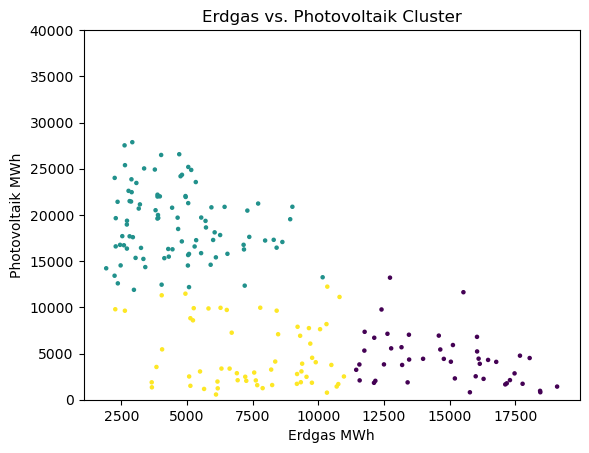

C:\Users\kmerlot\AppData\Local\Temp\ipykernel_436\197374384.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['percent'] = round((subset['count'] / subset['count'].sum()) * 100, 2)


,Jahreszeit,Cluster_seasons_1,count,percent
0,Spring,Spring,13,14.13
1,Spring,Summer,75,81.52
2,Spring,Winter,4,4.35


C:\Users\kmerlot\AppData\Local\Temp\ipykernel_436\197374384.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['percent'] = round((subset['count'] / subset['count'].sum()) * 100, 2)


,Jahreszeit,Cluster_seasons_1,count,percent
3,Summer,Summer,15,100.0


C:\Users\kmerlot\AppData\Local\Temp\ipykernel_436\197374384.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['percent'] = round((subset['count'] / subset['count'].sum()) * 100, 2)


,Jahreszeit,Cluster_seasons_1,count,percent
4,Winter,Spring,47,52.81
5,Winter,Summer,1,1.12
6,Winter,Winter,41,46.07


In [22]:
predictor = KMeans(n_clusters=3, random_state=42, n_init="auto")
y_pred = predictor.fit_predict(np.column_stack((df_day_daily['Erdgas'], df_day_daily['Photovoltaik'])))

fig, ax = plt.subplots()
ax.set_title('Erdgas vs. Photovoltaik Cluster')
ax.scatter(df_day_daily['Erdgas'], df_day_daily['Photovoltaik'], c=y_pred, s=5)
ax.set_ylim(0, 40000)
ax.set_xlabel('Erdgas MWh')
ax.set_ylabel('Photovoltaik MWh')
plt.show()

df_day_daily['Cluster_seasons_1'] = np.select([y_pred == 0, y_pred == 1, y_pred == 2], ['Winter', 'Summer', 'Spring'], default=None)

grouped = df_day_daily.groupby(['Jahreszeit', 'Cluster_seasons_1']).size().reset_index(name='count')

for season in grouped['Jahreszeit'].unique():
    subset = grouped[grouped['Jahreszeit'] == season]
    subset['percent'] = round((subset['count'] / subset['count'].sum()) * 100, 2)
    display(subset)
